#Introduction

In this notebook, we used a network composed of 5 convolutional blocks, composed by a convolution and a pool each, plus two fully connected layers with dropout. We have done some **modification to the dataset**:


*   We split the dataset with our script in:
    *   $75$% training set
    *   $15$% validation set
    *   $10$% test set
*   We balanced the dataset with the script made by us. We set $550$ as threshold for the training set, while $250$ for the validation set. We did not change the test set.

**Augmentation**:

*   We applied data augmentation, in order to avoid overfitting due to some classes which had really few samples in them, like the Raspberry one. This helped also to "fill" a little bit the gap due to the difference of our sets and the test set on the server.

**Patience** was set to $10$, and **Learning Rate** to $0,001$.

With this notebook we got a score of $65,09$%

#Mounting Drive

In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Checking which GPU I am running on

In [ ]:
!nvidia-smi

#Imports

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


#Loading data & folder Exploring

Extracting the zipped archive into the folder in which I am when I start the notebook (/content). We did this, because by extracting the zipped archive in the local folder of the runtime, speeds up a lot the first epoch in google Colab, and make its duration as shord as the following ones. This allowed us to save a lot of GPU time.

In [ ]:
!unzip /gdrive/MyDrive/AN2DL/leaves_test_overUnder_sampled.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: leaves_test_overUnder_sampled/val/Blueberry/02033.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01856.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01866.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01704.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01880.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/02206.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/02218.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01849.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/0_02151.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/1_01866.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/2_02222.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/3_01720.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/4_01745.jpg  
  inflating: leaves_test_overUnder_sampled/

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
dataset_dir = 'leaves_test_overUnder_sampled' #"leaves_test" is splitted like 75% train, 15% validation, 10%test for each class. "leaves_notest" is splitted like: 80% train, 20% validation, in case it's needed

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test') #to be commented if you use the dir "_notest", which have not test set (not recommended)

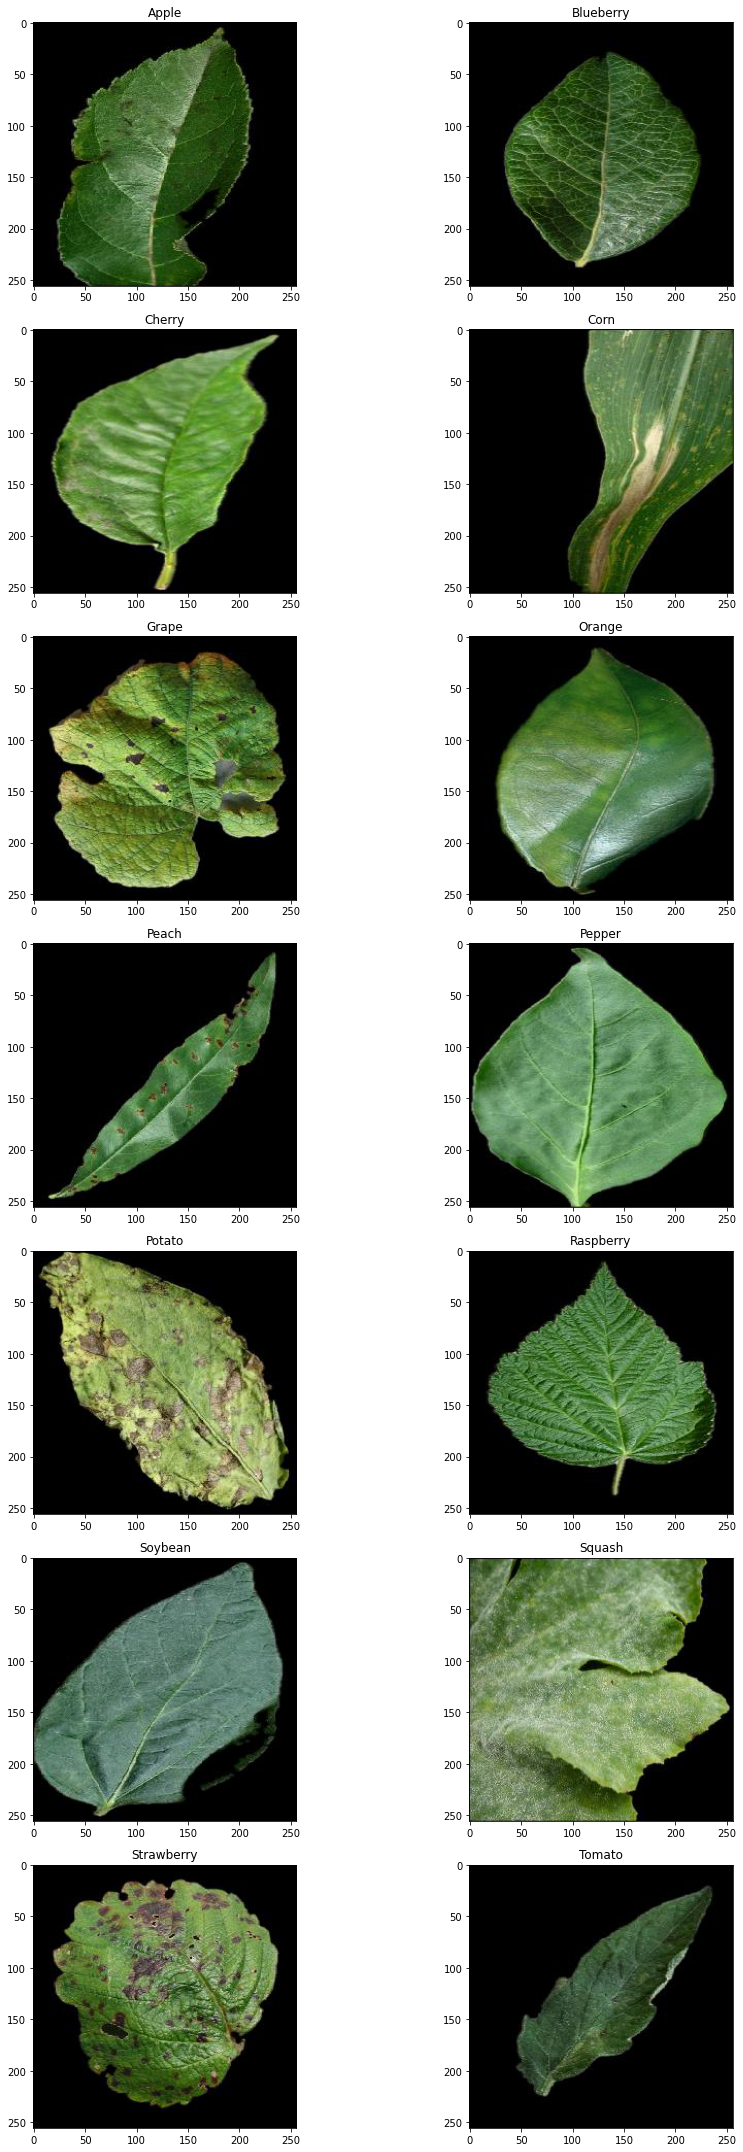

In [ ]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
# Inspect dataset structure on disk
print("Depth 0 (leaves_test_overUnder_sampled)")
print("-------")
!ls leaves_test_overUnder_sampled
print()
print("Depth 1 (e.g., leaves_test_overUnder_sampled/training)")
print("------------------------")
!ls leaves_test_overUnder_sampled/train
print()
print("Depth 2 (e.g., leaves_test_overUnder_sampled/training/Blueberry)")
print("----------------------------")
!ls leaves_test_overUnder_sampled/train/Blueberry

Depth 0 (leaves_test_overUnder_sampled)
-------
test  train  val

Depth 1 (e.g., leaves_test_overUnder_sampled/training)
------------------------
Apple	   Cherry  Grape   Peach   Potato     Soybean  Strawberry
Blueberry  Corn    Orange  Pepper  Raspberry  Squash   Tomato

Depth 2 (e.g., leaves_test_overUnder_sampled/training/Blueberry)
----------------------------
0_01840.jpg  01827.jpg	02005.jpg  02190.jpg		180_02029.jpg
01647.jpg    01828.jpg	02006.jpg  02191.jpg		18_01953.jpg
01649.jpg    01829.jpg	02007.jpg  02193.jpg		181_01653.jpg
01650.jpg    01830.jpg	02008.jpg  02195.jpg		182_14_01953.jpg
01652.jpg    01831.jpg	02009.jpg  02196.jpg		183_02081.jpg
01653.jpg    01832.jpg	02012.jpg  02197.jpg		184_01996.jpg
01654.jpg    01833.jpg	02014.jpg  02198.jpg		185_01973.jpg
01655.jpg    01835.jpg	02015.jpg  02199.jpg		186_01890.jpg
01656.jpg    01837.jpg	02019.jpg  02203.jpg		187_125_02212.jpg
01657.jpg    01838.jpg	02022.jpg  02205.jpg		188_02127.jpg
01658.jpg    01840.jpg	02023.jpg  022

#Data Generator

Import:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=180,
                                        height_shift_range=70,
                                        width_shift_range=120,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1/255.)
aug_valid_data_gen = ImageDataGenerator(rotation_range=180, # --- N.B. --- While trying to increase performances, we tried to perform data augmentation also here, because in some classes, like the raspberry one, when we oversampled the validation set, it contained many copies. Doing some researches, we found online that, sometimes, in some specific applications, this helped a little bit and we wanted to try
                                        height_shift_range=70,
                                        width_shift_range=120,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.) #to be commented if used with dataset "_notest" (not recommended)



# class_mode parameter not inserted: cathegorical (one hot coding) is the default one, hence, it is not necessary
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

aug_valid_gen = aug_valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

test_gen = test_data_gen.flow_from_directory(directory=test_dir,         #to be commented if used with dataset "_notest" (not recommended)
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=None,
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 7700 images belonging to 14 classes.
Found 3500 images belonging to 14 classes.
Found 1785 images belonging to 14 classes.


#Characteristics

In [ ]:
input_shape = (256, 256, 3)
epochs = 200

#Declaring Network

Let's work first with the network, and then declaring callbacks and checkpoints

In [ ]:
# Model used:
# (Conv + ReLU + MaxPool) x 5 + FC x 2
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Function which creates folders for callbacks

In [ ]:
from datetime import datetime

def create_folders_and_callbacks(model_name):
  #saving checkpoints on drive. We need to change directory, hence, we need ../ to go back of on folder, from /content to /
  #N.B.: after the following operation we don't need to go back, we did not change directory, we worked with the string of the path
  exps_dir = os.path.join('../gdrive/MyDrive/AN2DL/Checkpts/LucaA') #this is the directory in which will be saved all checkpoints of LucaA of all experiments
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now)) #here will be saved the checkpoints of this single experiment
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = [] #declare a list of empty callbacks

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts') #In the directory of the experiment will be created the directory ckpts
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

#Building Model

In [ ]:
# Build model
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496 

#Training the model

In [ ]:
# Create folders and callbacks and fit
aug_bal_callbacks = create_folders_and_callbacks(model_name = 'aug_balanced') #the model name will generate the folder of this single experiment

# restore checkpoints: (uncomment if needed)
#model.load_weights('/gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_10-10-02/ckpts/cp.ckpt')
#In this way, the training will restart from that specific checkpoint: clearly, Epoch number will restart from zero, but that's not a problem, it's restarting from the weights computed at ckpt

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = aug_valid_gen,
    callbacks = aug_bal_callbacks,
).history

Epoch 1/200
963/963 [==============================] - ETA: 0s - loss: 0.4427 - accuracy: 0.8603

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 199s 175ms/step - loss: 0.4427 - accuracy: 0.8603 - val_loss: 0.3701 - val_accuracy: 0.8783
Epoch 2/200
963/963 [==============================] - ETA: 0s - loss: 0.4407 - accuracy: 0.8623

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 174s 181ms/step - loss: 0.4407 - accuracy: 0.8623 - val_loss: 0.4333 - val_accuracy: 0.8654
Epoch 3/200
963/963 [==============================] - ETA: 0s - loss: 0.4238 - accuracy: 0.8678

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 177s 184ms/step - loss: 0.4238 - accuracy: 0.8678 - val_loss: 0.3939 - val_accuracy: 0.8769
Epoch 4/200
963/963 [==============================] - ETA: 0s - loss: 0.4761 - accuracy: 0.8597

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 178s 185ms/step - loss: 0.4761 - accuracy: 0.8597 - val_loss: 0.4165 - val_accuracy: 0.8717
Epoch 5/200
963/963 [==============================] - ETA: 0s - loss: 0.4717 - accuracy: 0.8606

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 178s 185ms/step - loss: 0.4717 - accuracy: 0.8606 - val_loss: 0.4614 - val_accuracy: 0.8531
Epoch 6/200
963/963 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.8578

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 178s 185ms/step - loss: 0.4640 - accuracy: 0.8578 - val_loss: 0.4487 - val_accuracy: 0.8546
Epoch 7/200
963/963 [==============================] - ETA: 0s - loss: 0.4442 - accuracy: 0.8716

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 177s 184ms/step - loss: 0.4442 - accuracy: 0.8716 - val_loss: 0.3334 - val_accuracy: 0.8940
Epoch 8/200
963/963 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.8632

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 173s 179ms/step - loss: 0.4570 - accuracy: 0.8632 - val_loss: 0.3496 - val_accuracy: 0.8900
Epoch 9/200
963/963 [==============================] - ETA: 0s - loss: 0.4371 - accuracy: 0.8727

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 180s 187ms/step - loss: 0.4371 - accuracy: 0.8727 - val_loss: 0.3685 - val_accuracy: 0.8900
Epoch 10/200
963/963 [==============================] - ETA: 0s - loss: 0.4376 - accuracy: 0.8675

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 178s 185ms/step - loss: 0.4376 - accuracy: 0.8675 - val_loss: 0.3922 - val_accuracy: 0.8800
Epoch 11/200
963/963 [==============================] - ETA: 0s - loss: 0.4407 - accuracy: 0.8675

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 179s 186ms/step - loss: 0.4407 - accuracy: 0.8675 - val_loss: 0.4112 - val_accuracy: 0.8757
Epoch 12/200
963/963 [==============================] - ETA: 0s - loss: 0.4394 - accuracy: 0.8686

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 179s 186ms/step - loss: 0.4394 - accuracy: 0.8686 - val_loss: 0.4281 - val_accuracy: 0.8577
Epoch 13/200
963/963 [==============================] - ETA: 0s - loss: 0.4394 - accuracy: 0.8695

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 181s 188ms/step - loss: 0.4394 - accuracy: 0.8695 - val_loss: 0.3324 - val_accuracy: 0.9029
Epoch 14/200
963/963 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.8671

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 182s 189ms/step - loss: 0.4455 - accuracy: 0.8671 - val_loss: 0.3720 - val_accuracy: 0.8803
Epoch 15/200
963/963 [==============================] - ETA: 0s - loss: 0.4378 - accuracy: 0.8671

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 187s 195ms/step - loss: 0.4378 - accuracy: 0.8671 - val_loss: 0.4335 - val_accuracy: 0.8691
Epoch 16/200
963/963 [==============================] - ETA: 0s - loss: 0.4325 - accuracy: 0.8726

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 186s 193ms/step - loss: 0.4325 - accuracy: 0.8726 - val_loss: 0.4622 - val_accuracy: 0.8577
Epoch 17/200
963/963 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.8736

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 183s 190ms/step - loss: 0.4147 - accuracy: 0.8736 - val_loss: 0.3465 - val_accuracy: 0.8914
Epoch 18/200
963/963 [==============================] - ETA: 0s - loss: 0.4382 - accuracy: 0.8734

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 182s 189ms/step - loss: 0.4382 - accuracy: 0.8734 - val_loss: 0.3571 - val_accuracy: 0.8903
Epoch 19/200
963/963 [==============================] - ETA: 0s - loss: 0.4602 - accuracy: 0.8661

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 180s 187ms/step - loss: 0.4602 - accuracy: 0.8661 - val_loss: 0.3120 - val_accuracy: 0.9074
Epoch 20/200
963/963 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.8756

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 173s 180ms/step - loss: 0.4180 - accuracy: 0.8756 - val_loss: 0.3567 - val_accuracy: 0.8840
Epoch 21/200
963/963 [==============================] - ETA: 0s - loss: 0.4209 - accuracy: 0.8712

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 175s 182ms/step - loss: 0.4209 - accuracy: 0.8712 - val_loss: 0.3729 - val_accuracy: 0.8860
Epoch 22/200
963/963 [==============================] - ETA: 0s - loss: 0.4400 - accuracy: 0.8683

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 173s 180ms/step - loss: 0.4400 - accuracy: 0.8683 - val_loss: 0.3716 - val_accuracy: 0.8797
Epoch 23/200
963/963 [==============================] - ETA: 0s - loss: 0.4278 - accuracy: 0.8749

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 169s 176ms/step - loss: 0.4278 - accuracy: 0.8749 - val_loss: 0.4517 - val_accuracy: 0.8700
Epoch 24/200
963/963 [==============================] - ETA: 0s - loss: 0.4413 - accuracy: 0.8687

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 166s 173ms/step - loss: 0.4413 - accuracy: 0.8687 - val_loss: 0.3854 - val_accuracy: 0.8800
Epoch 25/200
963/963 [==============================] - ETA: 0s - loss: 0.4253 - accuracy: 0.8769

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 168s 175ms/step - loss: 0.4253 - accuracy: 0.8769 - val_loss: 0.3377 - val_accuracy: 0.8903
Epoch 26/200
963/963 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.8648

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 189s 196ms/step - loss: 0.4599 - accuracy: 0.8648 - val_loss: 1.0307 - val_accuracy: 0.6971
Epoch 27/200
963/963 [==============================] - ETA: 0s - loss: 0.5870 - accuracy: 0.8300

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 186s 193ms/step - loss: 0.5870 - accuracy: 0.8300 - val_loss: 0.4392 - val_accuracy: 0.8657
Epoch 28/200
963/963 [==============================] - ETA: 0s - loss: 0.4404 - accuracy: 0.8703

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 181s 188ms/step - loss: 0.4404 - accuracy: 0.8703 - val_loss: 0.3341 - val_accuracy: 0.9011
Epoch 29/200
963/963 [==============================] - ETA: 0s - loss: 0.4066 - accuracy: 0.8803

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_Nov17_16-50-03/ckpts/cp.ckpt/assets


963/963 [==============================] - 182s 189ms/step - loss: 0.4066 - accuracy: 0.8803 - val_loss: 0.3546 - val_accuracy: 0.8994


#Saving the model

In [ ]:
%cd /gdrive/MyDrive/AN2DL/models

/gdrive/MyDrive/AN2DL/models


In [ ]:
# Save best epoch model
model.save("Models/LucaA/Augmented_Balanced")

INFO:tensorflow:Assets written to: Models/LucaA/Augmented_Balanced/assets


INFO:tensorflow:Assets written to: Models/LucaA/Augmented_Balanced/assets


#Plot training error and validation error

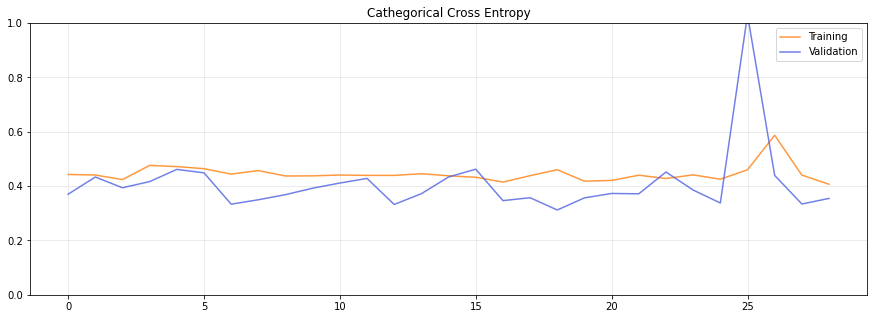

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Cathegorical Cross Entropy')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

#Testing
N.B.: this cells can be executed only if considering the dataset with the test folder (recommend to use the dataset with the test folder)

In [ ]:
cd /content

/content


In [ ]:
model_to_be_tested = tfk.models.load_model("../gdrive/MyDrive/AN2DL/models/Models/LucaA/Augmented_Balanced")
model_to_be_tested_metrics = model_to_be_tested.evaluate(test_gen, return_dict=True)

224/224 [==============================] - 10s 44ms/step - loss: 0.4027 - accuracy: 0.8924
